<a href="https://colab.research.google.com/github/DataMais/DataMais/blob/main/Vacinacao_Benford.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Célula para montar o drive Google neste notebook. Será pedido autorização para fazer a conexão. 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#link para código de todos municípios brasileiros 

url = "https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv"

#dataset com os códigos IBGE para os municípios brasileiros
dfloc = pd.read_csv(url, 
                   dtype={"codigo_ibge":"object"})

def tratacodigo(x): #padronização do código para 6 dígitos
    return x[0:-1] 
dfloc.codigo_ibge = dfloc.codigo_ibge.apply(tratacodigo)

dfloc = dfloc.set_index("codigo_ibge")
dfloc.columns = ['Município', 'latitude', 'longitude', 'capital', 'codigo_uf']

In [ ]:
UF = "AC" #Definindo Estado. Mudar aqui o valor para obter dataset de outro estado

#colunas disponíveis nos arquivos de vacinação
colunas = ['document_id', 'paciente_id', 'paciente_idade',
       'paciente_datanascimento', 'paciente_enumsexobiologico',
       'paciente_racacor_codigo', 'paciente_racacor_valor',
       'paciente_endereco_coibgemunicipio', 'paciente_endereco_copais',
       'paciente_endereco_nmmunicipio', 'paciente_endereco_nmpais',
       'paciente_endereco_uf', 'paciente_endereco_cep',
       'paciente_nacionalidade_enumnacionalidade', 'estabelecimento_valor',
       'estabelecimento_razaosocial', 'estalecimento_nofantasia',
       'estabelecimento_municipio_codigo', 'estabelecimento_municipio_nome',
       'estabelecimento_uf', 'vacina_grupoatendimento_codigo',
       'vacina_grupoatendimento_nome', 'vacina_categoria_codigo',
       'vacina_categoria_nome', 'vacina_lote', 'vacina_fabricante_nome',
       'vacina_fabricante_referencia', 'vacina_dataaplicacao',
       'vacina_descricao_dose', 'vacina_codigo', 'vacina_nome',
       'sistema_origem', 'data_importacao_rnds', 'id_sistema_origem']

colunadatas = [] #Configurando colunas de datas
for i in colunas:
    if "data" in i:
        colunadatas.append(i)


df = pd.read_csv(f"https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/PNI/vacina/uf/2021-05-25/uf%3D{UF}/part-00000-b6cdd746-4f91-45c3-8716-efd6d4734c52.c000.csv", 
                 parse_dates = colunadatas, 
                 dtype={"estabelecimento_municipio_codigo":"object"},
                 delimiter=";")

municipios = [i for i in df.estabelecimento_municipio_codigo.unique()] #obtendo os códigos de todos os municípios do estado UF
dftemp = df.groupby(['estabelecimento_municipio_codigo','vacina_dataaplicacao'],as_index=False).agg({'document_id':'count'}).sort_values(by="vacina_dataaplicacao")
dftemp2 = dftemp.set_index(["vacina_dataaplicacao", "estabelecimento_municipio_codigo"])
dftemp2["primeiro_digito"] = dftemp2["document_id"].apply(lambda x: int(str(x)[0]))#capturando dados de primeiros dígitos dos municípios

dftemp3 = dftemp2.reset_index() 

dicios = dict() #criando dicionário com a frequência dos primeiros dígitos
for i in municipios:
    dfmun = dftemp3[dftemp3["estabelecimento_municipio_codigo"]==i]
    freq = dfmun["primeiro_digito"].value_counts().to_dict()
    dicios[i] = [i/len(dfmun) for i in freq.values()]
    
BENFORD = [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6] #distribuição esperada da lei de Benford   
benforddic = dict()
for i in range(len(BENFORD)):
    benforddic[i+1] = BENFORD[i]/100 #criando o dicionário com valores Benford
distdf = pd.DataFrame.from_dict(dicios, orient="index")
distdf.columns = [1,2,3,4,5,6,7,8,9]

distdf = distdf.append(benforddic, ignore_index=True) #incluindo a referência dos valores Benford


municipios.append(0)

distdf.index = municipios #alterando índice para os códigos de municípios

distdf = distdf.rename(index={0:"Dist_Benford"}) #Formatação final dos nomes dos índices
distdf = distdf.dropna() #retirando linhas com valores faltantes 
distdf.index.name = "codigo_ibge"
distdf.to_csv(f"/content/drive/MyDrive/dfBen{UF}.csv") #o arquivo só será salvo no Drive se o disco estiver montado

distdf.join(dfloc['Município'])[['Município', 1, 2, 3, 4, 5, 6, 7, 8, 9]] #exemplo de Dataset com código e nome dos municípios

,Município,1,2,3,4,5,6,7,8,9
codigo_ibge,,,,,,,,,,
120050,Sena Madureira,0.368421,0.189474,0.126316,0.094737,0.084211,0.063158,0.042105,0.021053,0.010526
120040,Rio Branco,0.386555,0.176471,0.092437,0.084034,0.084034,0.067227,0.058824,0.033613,0.016807
120020,Cruzeiro do Sul,0.272727,0.263636,0.109091,0.090909,0.090909,0.063636,0.063636,0.027273,0.018182
120035,Marechal Thaumaturgo,0.369565,0.206522,0.108696,0.108696,0.065217,0.054348,0.043478,0.021739,0.021739
120005,Assis Brasil,0.319588,0.185567,0.175258,0.082474,0.072165,0.061856,0.051546,0.041237,0.010309
120033,Mâncio Lima,0.284404,0.174312,0.110092,0.110092,0.082569,0.073394,0.055046,0.055046,0.055046
120001,Acrelândia,0.276316,0.197368,0.184211,0.105263,0.065789,0.052632,0.039474,0.039474,0.039474
120060,Tarauacá,0.350515,0.123711,0.123711,0.103093,0.092784,0.061856,0.061856,0.041237,0.041237
120043,Santa Rosa do Purus,0.255319,0.180851,0.170213,0.148936,0.085106,0.063830,0.042553,0.031915,0.021277


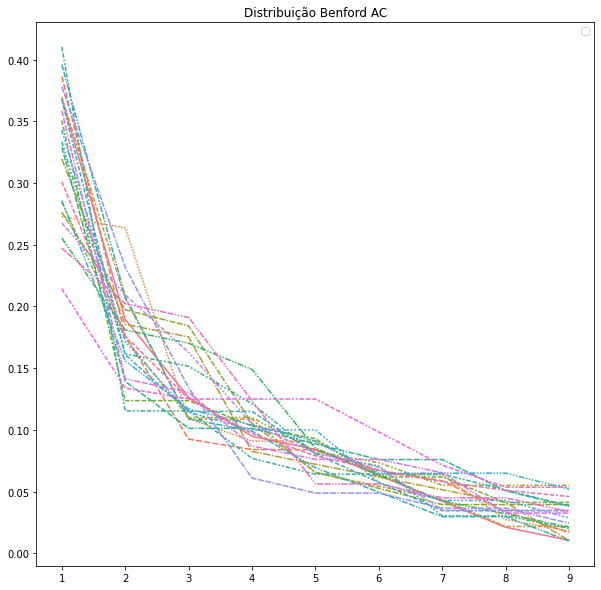

In [ ]:
plt.figure(figsize=(10,10)); #Gráfico mostrando tendência geral de acompanhar a curva Benford
sns.lineplot(data=distdf.T);
plt.legend("")
plt.title(f"Distribuição Benford {UF}")
plt.savefig(f"/content/drive/MyDrive/{UF}Benford.png")

In [ ]:
from scipy.stats import chisquare #importando biblioteca para teste quiquadrado

resultado = chisquare(f_obs=distdf.iloc[0:-1, :], f_exp=distdf.iloc[-1,:], axis=1) #aplicação teste Quiquadrado

df2 = distdf.join(dfloc['Município'])[['Município', 1, 2, 3, 4, 5, 6, 7, 8, 9]]
codigo_ibge = df2.index[0:-1].values
estatisticas = resultado[0]
valorp = resultado[1]
municipios = df2["Município"][:-1].values
dicioval = {"Código IBGE": codigo_ibge, "Município":municipios, "Estatística Qui":estatisticas, "Valor p":valorp}

quidf = pd.DataFrame(data=dicioval).set_index("Código IBGE") #Novo Dataset com os resultados do teste quidradao
quidf.head()

,Município,Estatística Qui,Valor p
Código IBGE,,,
120050,Sena Madureira,0.066061,1.0
120040,Rio Branco,0.059323,1.0
120020,Cruzeiro do Sul,0.079074,1.0
120035,Marechal Thaumaturgo,0.062462,1.0
120005,Assis Brasil,0.055315,1.0


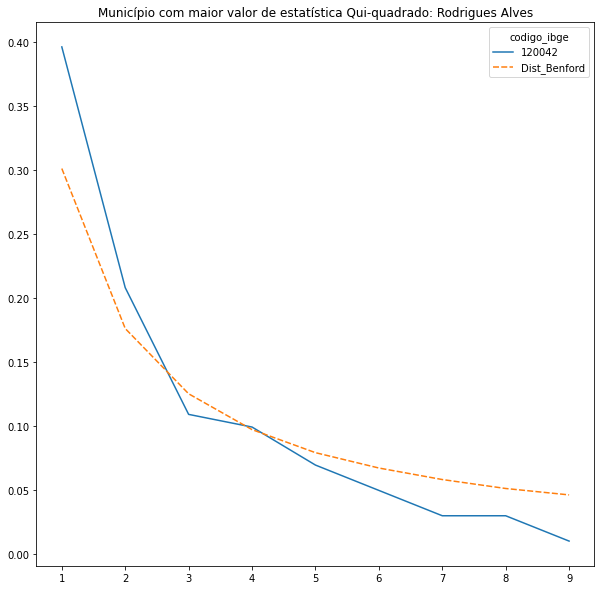

In [ ]:
maior_valor = quidf.sort_values(by="Valor p", ascending=True).index[0] #Capturando o município com maior disparidade de valores na tabela
maior_municipio = quidf.sort_values(by="Valor p", ascending=True)["Município"][0]

plt.figure(figsize=(10,10)) #Exemplo de município destoando da curva (Devido população pequena?)
sns.lineplot(data=distdf.T[[maior_valor,"Dist_Benford"]]);

plt.title(f"Município com maior valor de estatística Qui-quadrado: {maior_municipio}");
plt.savefig(f"/content/drive/MyDrive/{UF}MunicipioMaiorBenford.png")